In [2]:
# note: fdfdpy must be in your JUPYTER_PATH for this import to work (or you can manually add it to path with some google=able code.)
from fdfdpy.Fdfd import Fdfd
from nonlinear_solvers import born_solve, newton_solve
from optimization import run_optimization

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
omega = 5e14                # angular frequency (2pi)
dl = 1e-1                   # grid size (m)
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [4]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [5]:
# set source and solve for electromagnetic fields
b = np.zeros((simulation.Nx,simulation.Ny))
b[40:60,30] = 1
(Hx,Hy,Ez) = simulation.solve_fields(b)

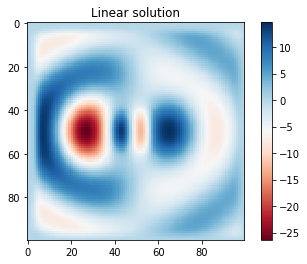

In [6]:
# plot
plt.imshow(np.real(Ez), cmap='RdBu')
plt.colorbar()
plt.title('Linear solution')
plt.show()

In [7]:
# This is where we define stuff for the optimization

eps_max = 5
Nsteps = 10
Jregion = np.zeros(eps_r.shape)
Jregion[50, 80] = 1

# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['nonlinear'] = None
J['total']     = lambda Jlin, Jnonlin: Jlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*Jregion
dJdE['nonlinear'] = None
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin

design_region = np.array(eps_r > 1).astype(int)

In [8]:
obj_fns = run_optimization(simulation, b, J, dJdE, design_region, Nsteps, eps_max, solver='born', step_size=0.2)

100% (10 of 10) |########################| Elapsed Time: 0:00:01 ETA:  00:00:00

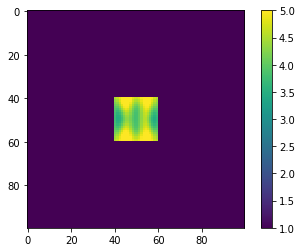

In [9]:
plt.imshow(simulation.eps_r)
plt.colorbar()
plt.show()

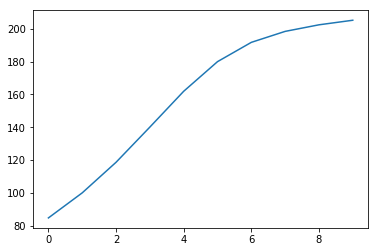

In [10]:
plt.plot(obj_fns)
plt.show()

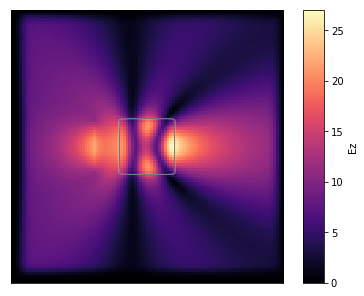

In [11]:
(Hx,Hy,Ez) = simulation.solve_fields(b)
simulation.plt_abs()

In [53]:
# Now try running the same thing but with nonlinearity 
# Should be the same for this amount of input power and choice of chi-3

chi3 = 2.8*1e-18         # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2        # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2
nl_region = design_region  # Nonliearity region
# Define nonlinear function
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
# Define the partial derivative of the nonlinear function w.r.t. e
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)

In [54]:
# Reset simulation
simulation.reset_eps(eps_r)

In [55]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['nonlinear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['linear'] = None
J['total']     = lambda Jlin, Jnonlin: Jnonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['nonlinear']    = lambda e: np.conj(e)*Jregion
dJdE['linear'] = None
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_nonlin

In [56]:
obj_fns = run_optimization(simulation, b, J, dJdE, design_region, Nsteps, eps_max, kerr_nonlinearity, nl_region,
                           kerr_nl_de, solver='newton', step_size=0.2)

100% (10 of 10) |########################| Elapsed Time: 0:00:03 ETA:  00:00:00

In [ ]:
# Note: takes a bit longer because the nonlinear solvers still need to solve at the very least twice to 
# know that the result is converged 

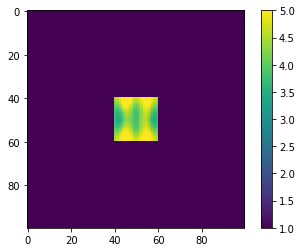

In [57]:
plt.imshow(simulation.eps_r)
plt.colorbar()
plt.show()

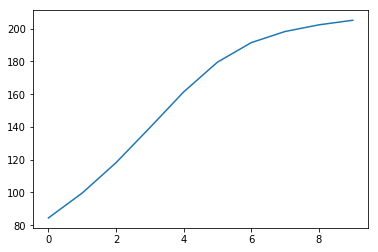

In [58]:
plt.plot(obj_fns)
plt.show()